#**Store Sales - Time Series Forecasting Project**
**Joaquín Rodríguez Villegas**

El siguiente proyecto tiene el propósito de predecir las ventas para los miles de productos vendidos en las tiendas "Favorita" de Ecuador usando métodos estadísticos avanzados de series de tiempo. Se cuenta originalmente con 7 conjuntos de datos descargados de la plataforma Kaggle y se comienza haciendo un análisis exploratorio y visualización de los datos para descubrir tendencias e insights interesantes. Luego se emplean los métodos estadísticos de series de tiempo para hacer la predicción de las ventas y con eso, calcular el mínimo RMSLE que maximice la calidad del modelo.

#Importación de librerías 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from pathlib import Path
from dateutil.parser import parse 
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import pylab as py

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#Preparación de datos

In [ ]:
#Holiday Events
holiday_df = pd.read_csv('https://raw.githubusercontent.com/joaquinrovi/Analitica-de-datos/main/holidays_events.csv')
holiday_df.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
#Oil 
Oil_df = pd.read_csv('https://raw.githubusercontent.com/joaquinrovi/Analitica-de-datos/main/oil.csv')
Oil_df.head(5)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [ ]:
#Sample Submission (Just how submissions must be delivered)
Sample_df = pd.read_csv('https://raw.githubusercontent.com/joaquinrovi/Analitica-de-datos/main/sample_submission.csv')
Sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28512 non-null  int64  
 1   sales   28512 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 445.6 KB


In [ ]:
#Stores
Store_df = pd.read_csv('https://raw.githubusercontent.com/joaquinrovi/Analitica-de-datos/main/stores.csv')
Store_df.head(5)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
#Transactions
Trans_df = pd.read_csv('https://raw.githubusercontent.com/joaquinrovi/Analitica-de-datos/main/transactions.csv')
Trans_df.head(5)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [ ]:
#Train 
Train_df = pd.read_csv('train2.csv')
Train_df.head(5)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


In [ ]:
#Test
Test_df = pd.read_csv('https://raw.githubusercontent.com/joaquinrovi/Analitica-de-datos/main/test.csv')
Test_df.head(5)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


#Visualización de datos y EDA

##Holiday Events

In [ ]:
holiday_df.shape

(350, 6)

In [ ]:
holiday_df.isna().sum().sum()

0

In [ ]:
type(holiday_df['date'])
holiday_df.date = pd.to_datetime(holiday_df.date, format = '%Y-%m-%d')
holiday_df['date'] = holiday_df.date

In [ ]:
holiday_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [ ]:
holiday_df.head(2)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False


In [ ]:
def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

In [ ]:
holiday_df['type'].value_counts()

Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


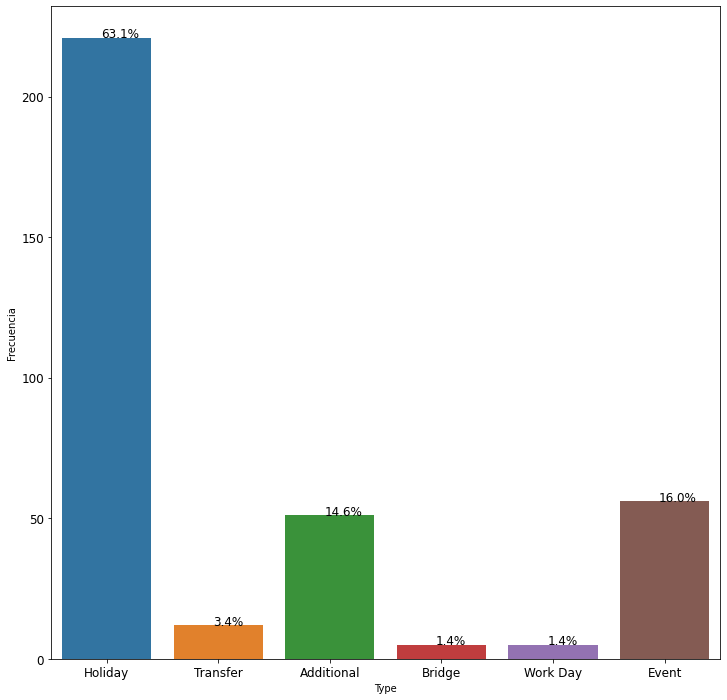

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.countplot(holiday_df['type'])
plt.xticks(size = 12)
plt.xlabel('Type')
plt.yticks(size = 12)
plt.ylabel('Frecuencia')

without_hue(ax, holiday_df.type)

In [ ]:
holiday_df['locale'].value_counts()

National    174
Local       152
Regional     24
Name: locale, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


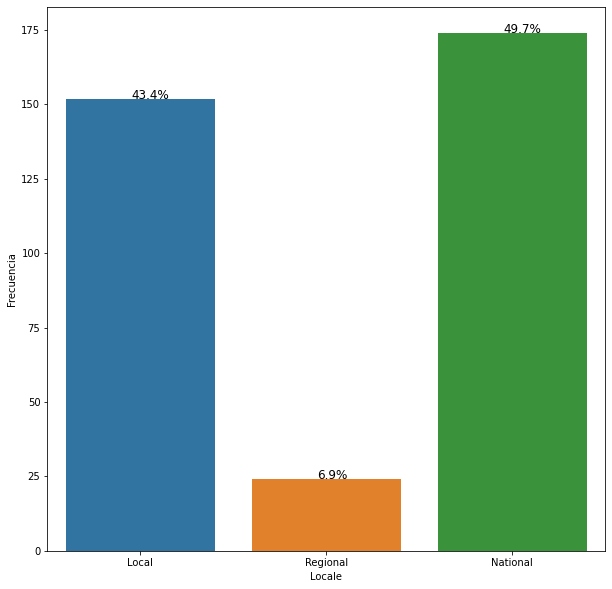

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.countplot(holiday_df['locale'])
plt.xticks(size = 10)
plt.xlabel('Locale')
plt.yticks(size = 10)
plt.ylabel('Frecuencia')

without_hue(ax, holiday_df.locale)

In [ ]:
holiday_df['locale_name'].value_counts()

Ecuador                           174
Quito                              13
Riobamba                           12
Guaranda                           12
Latacunga                          12
Ambato                             12
Guayaquil                          11
Cuenca                              7
Ibarra                              7
Salinas                             6
Loja                                6
Santa Elena                         6
Santo Domingo de los Tsachilas      6
Quevedo                             6
Manta                               6
Esmeraldas                          6
Cotopaxi                            6
El Carmen                           6
Santo Domingo                       6
Machala                             6
Imbabura                            6
Puyo                                6
Libertad                            6
Cayambe                             6
Name: locale_name, dtype: int64

In [ ]:
def with_hue(ax, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in ax.patches]
    patch = [p for p in ax.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)

In [ ]:
holiday_df['transferred'].value_counts()

False    338
True      12
Name: transferred, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


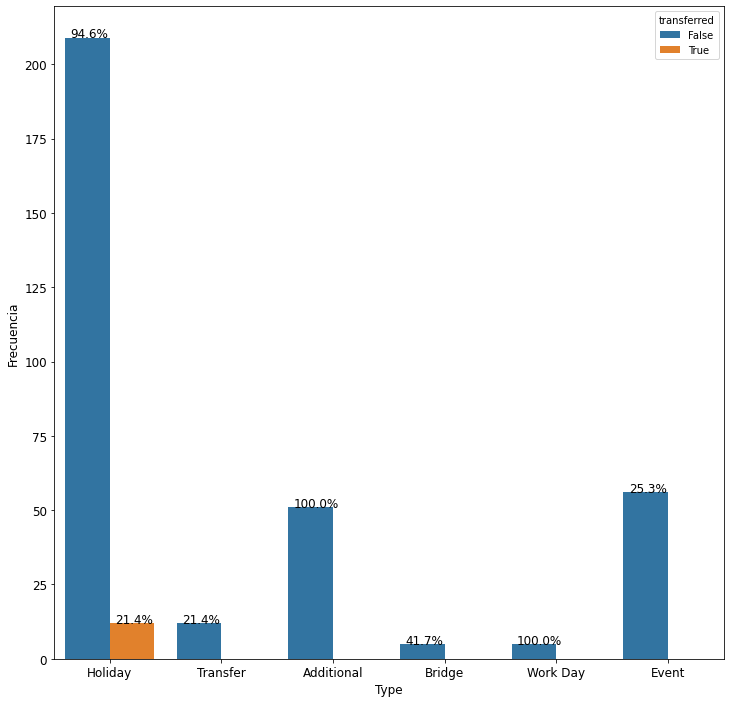

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.countplot('type', hue = 'transferred', data = holiday_df)
plt.xticks(size = 12)
plt.xlabel('Type', size = 12)
plt.yticks(size = 12)
plt.ylabel('Frecuencia', size = 12)

with_hue(ax, holiday_df.type, 5, 2)

##Oil

In [ ]:
Oil_df.shape

(1218, 2)

In [ ]:
pd.set_option('display.max_rows', Oil_df.isna().sum().shape[0]+1)
print(Oil_df.isna().sum())

date           0
dcoilwtico    43
dtype: int64


In [ ]:
type(Oil_df['date'])
Oil_df.date = pd.to_datetime(Oil_df.date, format = '%Y-%m-%d')
Oil_df['date'] = Oil_df.date

In [ ]:
Oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [ ]:
#Use dropNaN values in rows, then graph the histogram
Oil_df.dropna(subset = ['dcoilwtico'], inplace=True)

In [ ]:
Oil_df.head(2)

,date,dcoilwtico
1,2013-01-02,93.14
2,2013-01-03,92.97


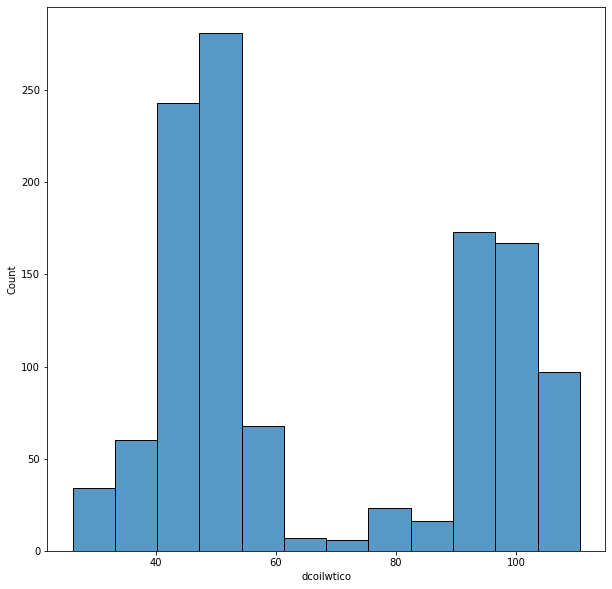

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(x = Oil_df['dcoilwtico'], data = Oil_df)

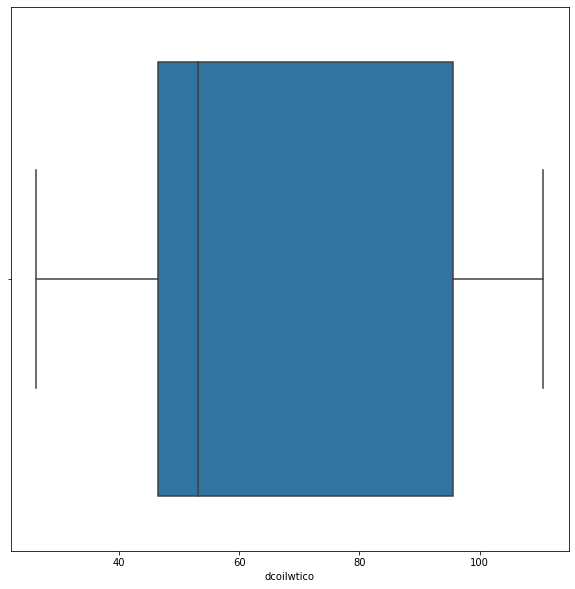

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(x = Oil_df['dcoilwtico'], data = Oil_df)

In [ ]:
Oil_df['dcoilwtico'].describe()

count    1175.000000
mean       67.714366
std        25.630476
min        26.190000
25%        46.405000
50%        53.190000
75%        95.660000
max       110.620000
Name: dcoilwtico, dtype: float64

In [ ]:
#Normality Test (Shapiro Wilk)
#Null Hypothesis: The data is normaly (gaussian) distributed
#Alternative Hypothesis: The data is not normally distributed (p-value < 0.05)
#SW-statistic, p-value (alfa = 0.05)
stats.shapiro(Oil_df['dcoilwtico'])

(0.8390869498252869, 7.35939250293814e-33)

In [ ]:
stats.kstest(Oil_df['dcoilwtico'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

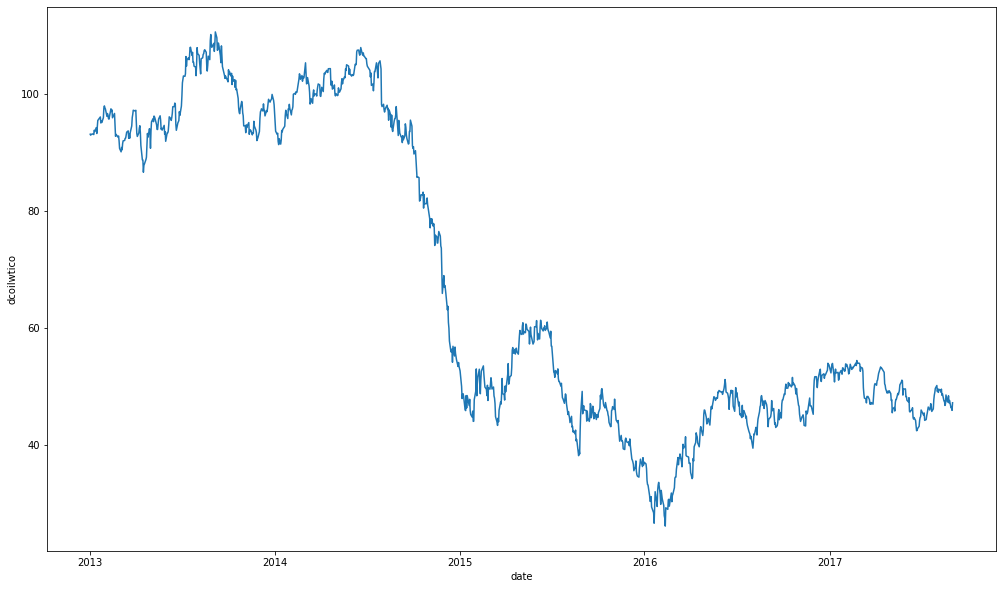

In [ ]:
plt.figure(figsize=(17,10))
sns.lineplot(x = Oil_df['date'], y = Oil_df['dcoilwtico'], data = Oil_df)
ax.set_title('Time Series Oil');

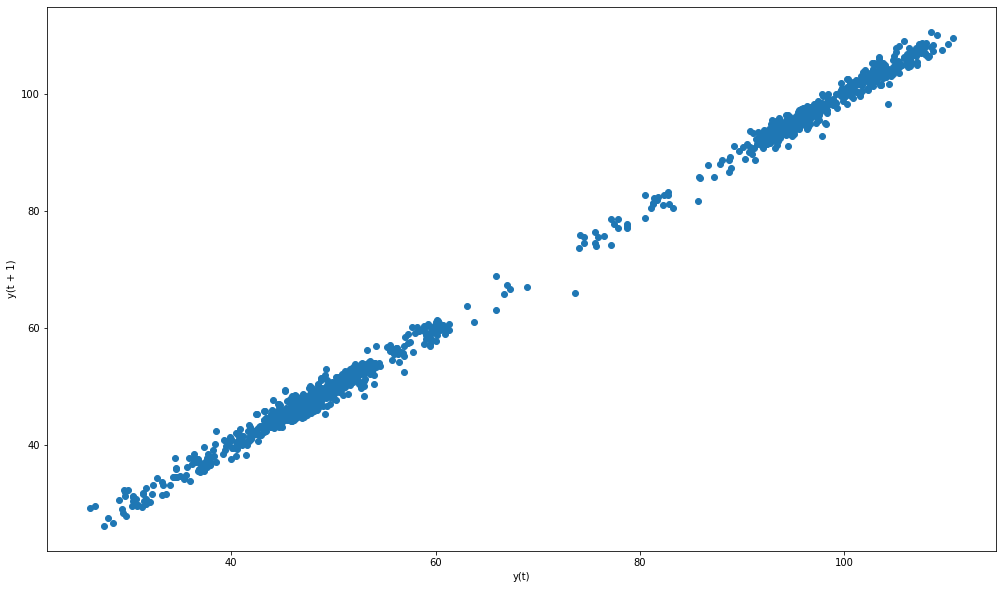

In [ ]:
plt.figure(figsize=(17,10))
lag_plot(Oil_df['dcoilwtico'], lag=1)

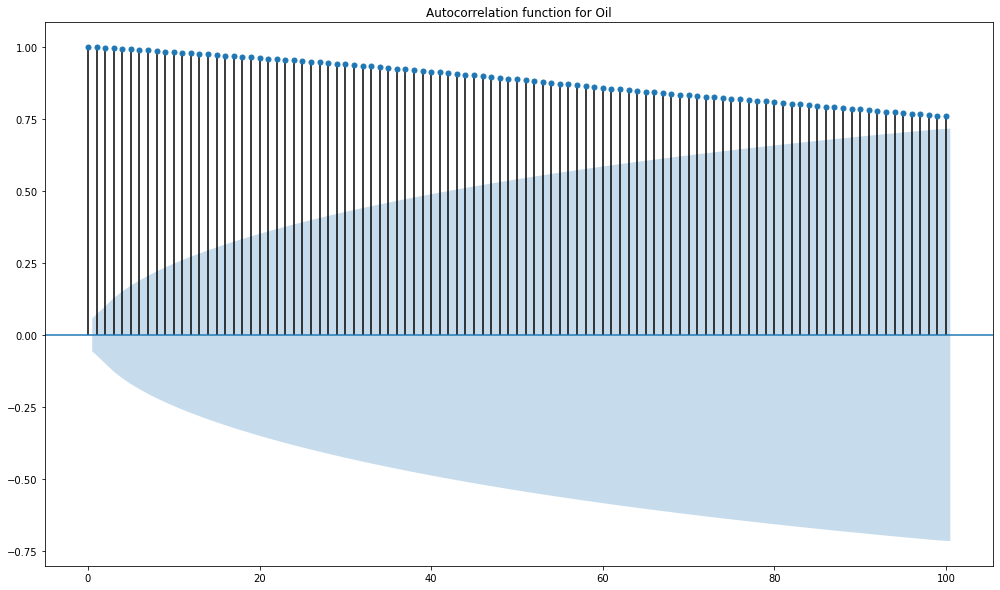

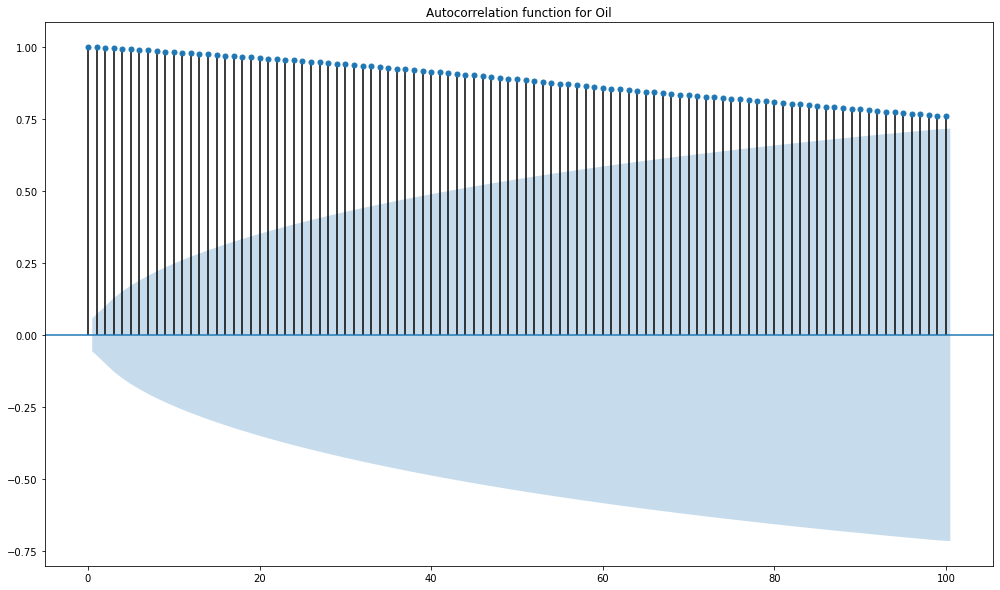

In [ ]:
plt.rc("figure", figsize=(17,10))
plot_acf(Oil_df['dcoilwtico'], lags = 100, alpha=0.05, title='Autocorrelation function for Oil')

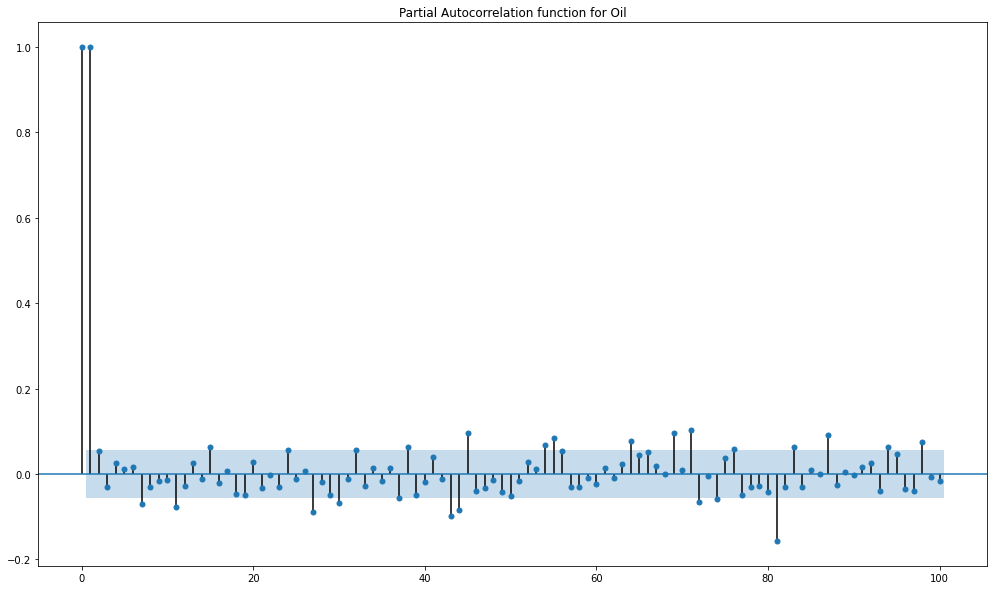

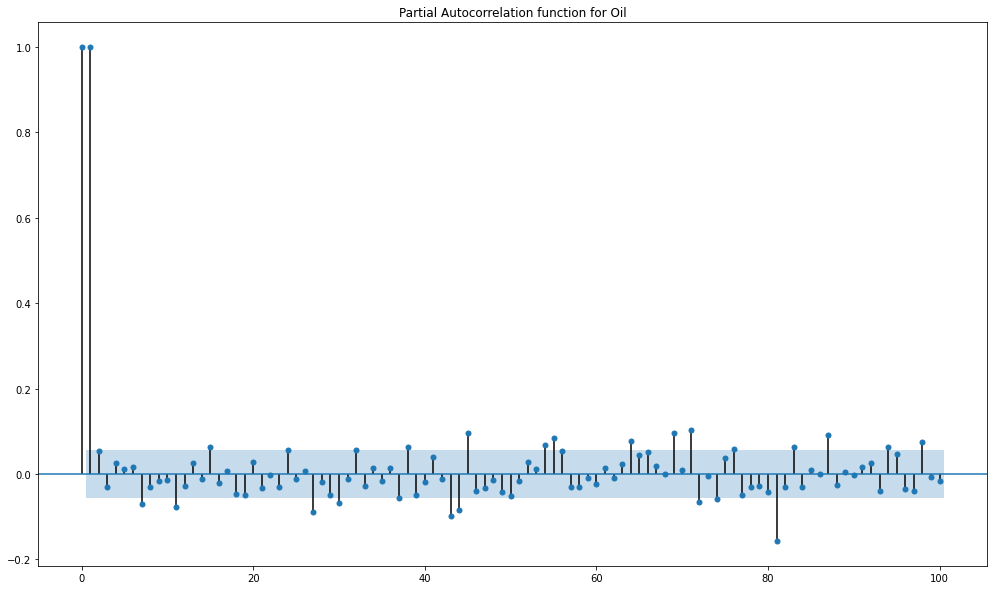

In [ ]:
plt.rc("figure", figsize=(17,10))
plot_pacf(Oil_df['dcoilwtico'], lags = 100, alpha=0.05, title='Partial Autocorrelation function for Oil')

In [ ]:
#Serial correlation test (Autocorrelation)
#Null Hypothesis: Data is independently distributed
#Alternative Hypothesis: Data is not independently distributed (serial correlated) (p-value < 0.05)
sm.stats.acorr_ljungbox(Oil_df['dcoilwtico'], lags = 1000)

(array([  1173.6871922 ,   2344.32317079,   3511.76460122,   4676.15304416,
          5837.53656727,   6995.99633147,   8151.21500036,   9303.10381537,
         10451.59171272,  11596.64516789,  12737.9418082 ,  13875.42107323,
         15009.18494109,  16139.17764121,  17265.70971552,  18388.65742372,
         19508.04453313,  20623.62271898,  21735.20949627,  22842.92554358,
         23946.6517543 ,  25046.4120648 ,  26142.11004045,  27233.9847696 ,
         28321.962439  ,  29406.10629027,  30485.9989265 ,  31561.59453666,
         32632.60441656,  33698.86481039,  34760.34970118,  35817.35607378,
         36869.72486027,  37917.55526998,  38960.73720291,  39999.26330055,
         41032.85681006,  42061.79932552,  43085.85368843,  44104.95852177,
         45119.34294774,  46129.00335328,  47133.54999128,  48132.72326419,
         49126.85878182,  50115.740042  ,  51099.28359551,  52077.45867068,
         53050.08302021,  54016.95081671,  54978.11854932,  55933.67979346,
         568

##Stores

In [ ]:
Store_df.shape

(54, 5)

In [ ]:
Store_df.isna().sum().sum()

0

In [ ]:
Store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [ ]:
Store_df['store_nbr'].value_counts()

1     1
41    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
42    1
2     1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
50    1
51    1
52    1
53    1
29    1
28    1
27    1
26    1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
54    1
Name: store_nbr, dtype: int64

In [ ]:
Store_df['city'].value_counts()

Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Machala           2
Ambato            2
Quevedo           1
Esmeraldas        1
Loja              1
Libertad          1
Playas            1
Daule             1
Babahoyo          1
Salinas           1
Puyo              1
Guaranda          1
Ibarra            1
Riobamba          1
Cayambe           1
El Carmen         1
Name: city, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


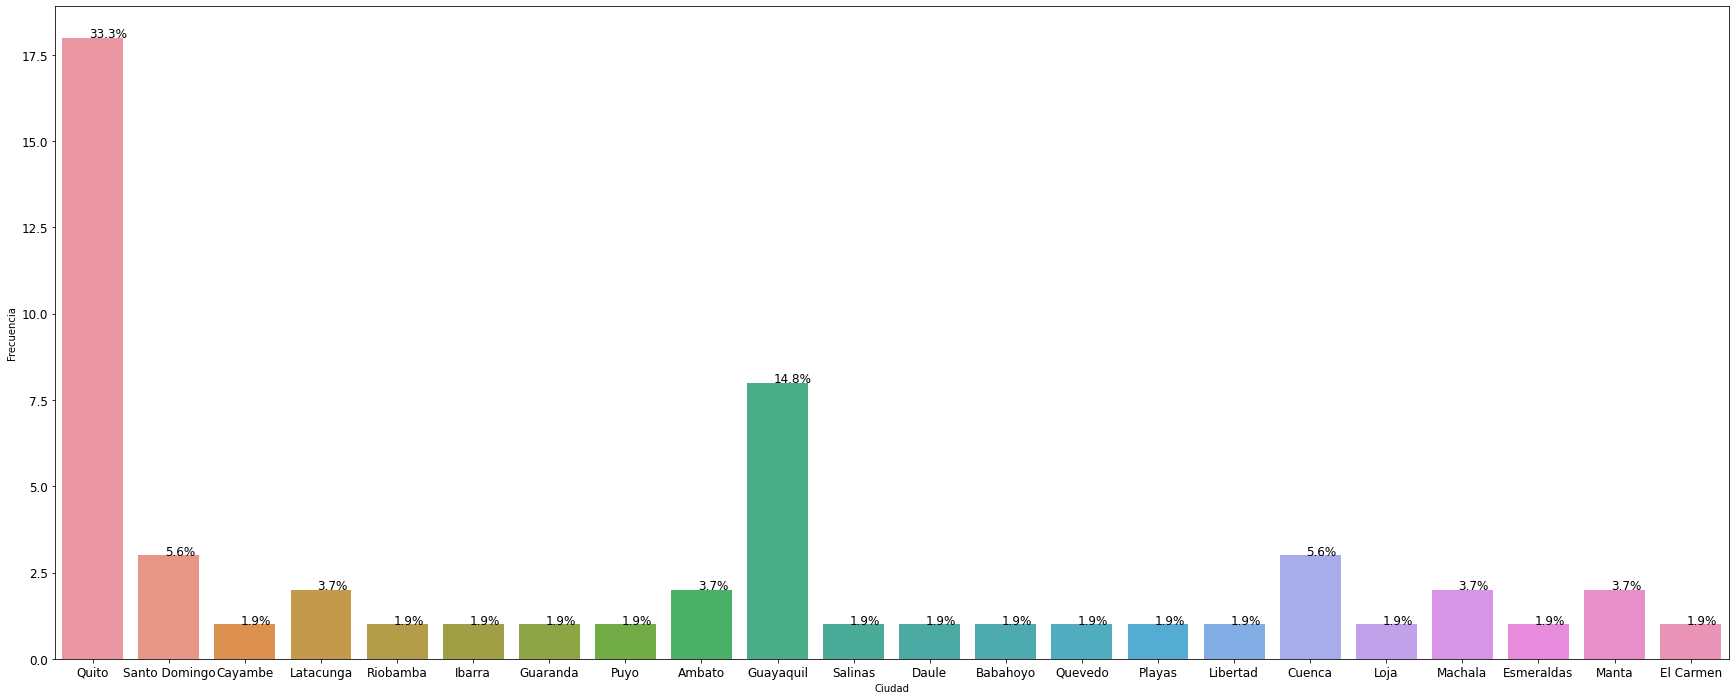

In [ ]:
plt.figure(figsize=(30,12))
ax = sns.countplot(Store_df['city'])
plt.xticks(size = 12)
plt.xlabel('Ciudad')
plt.yticks(size = 12)
plt.ylabel('Frecuencia')

without_hue(ax, Store_df.city)

In [ ]:
Store_df['state'].value_counts()

Pichincha                         19
Guayas                            11
Santo Domingo de los Tsachilas     3
Azuay                              3
Manabi                             3
Cotopaxi                           2
Tungurahua                         2
Los Rios                           2
El Oro                             2
Chimborazo                         1
Imbabura                           1
Bolivar                            1
Pastaza                            1
Santa Elena                        1
Loja                               1
Esmeraldas                         1
Name: state, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


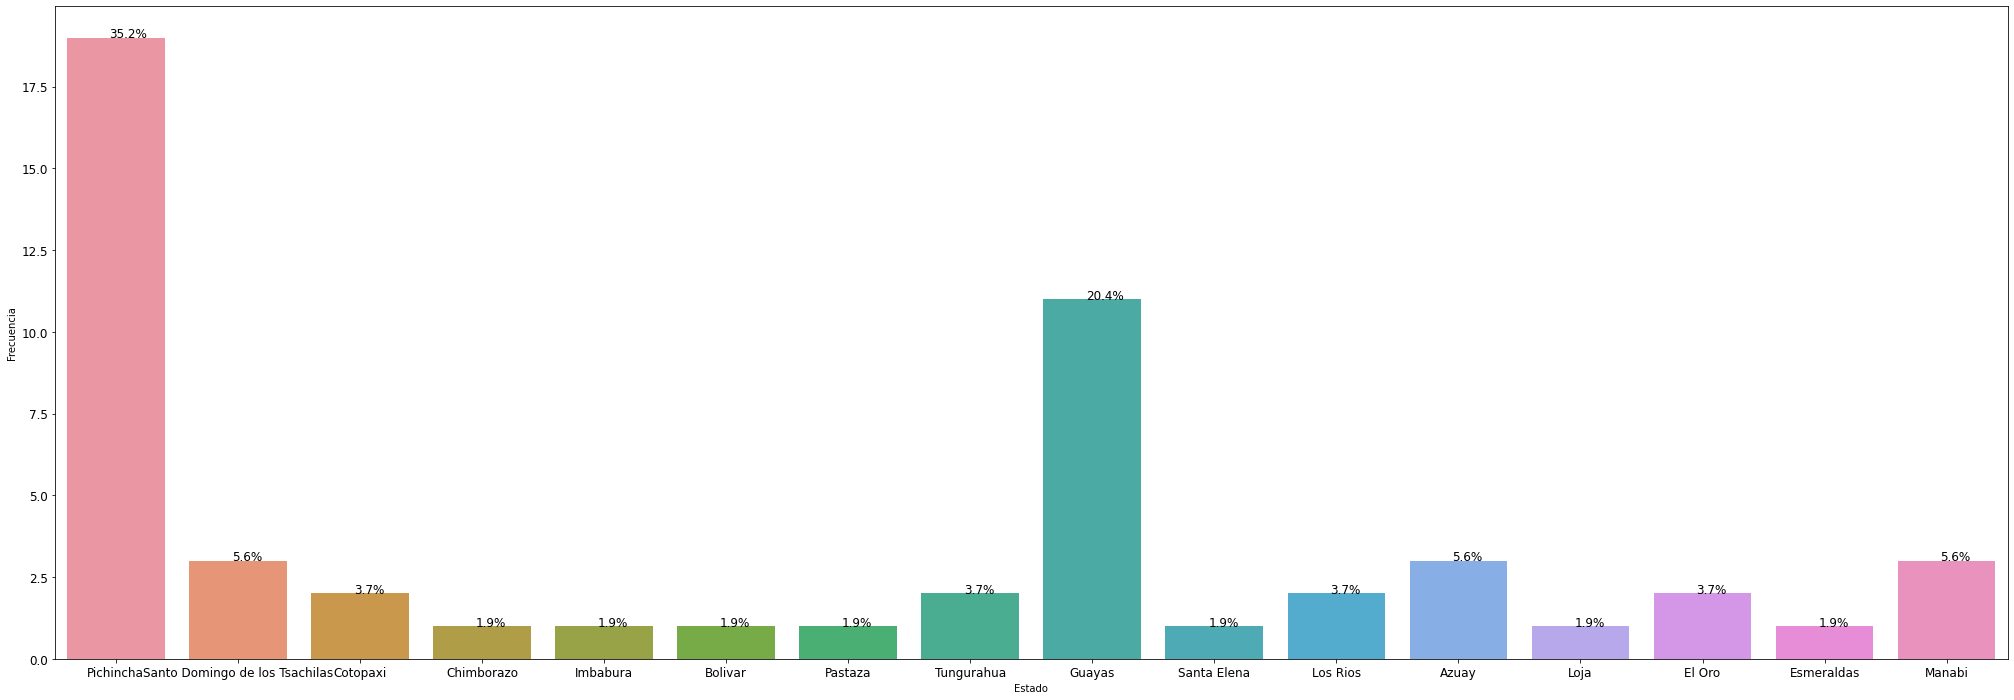

In [ ]:
plt.figure(figsize=(35,12))
ax = sns.countplot(Store_df['state'])
plt.xticks(size = 12)
plt.xlabel('Estado')
plt.yticks(size = 12)
plt.ylabel('Frecuencia')

without_hue(ax, Store_df.state)

In [ ]:
Store_df['type'].value_counts()

D    18
C    15
A     9
B     8
E     4
Name: type, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


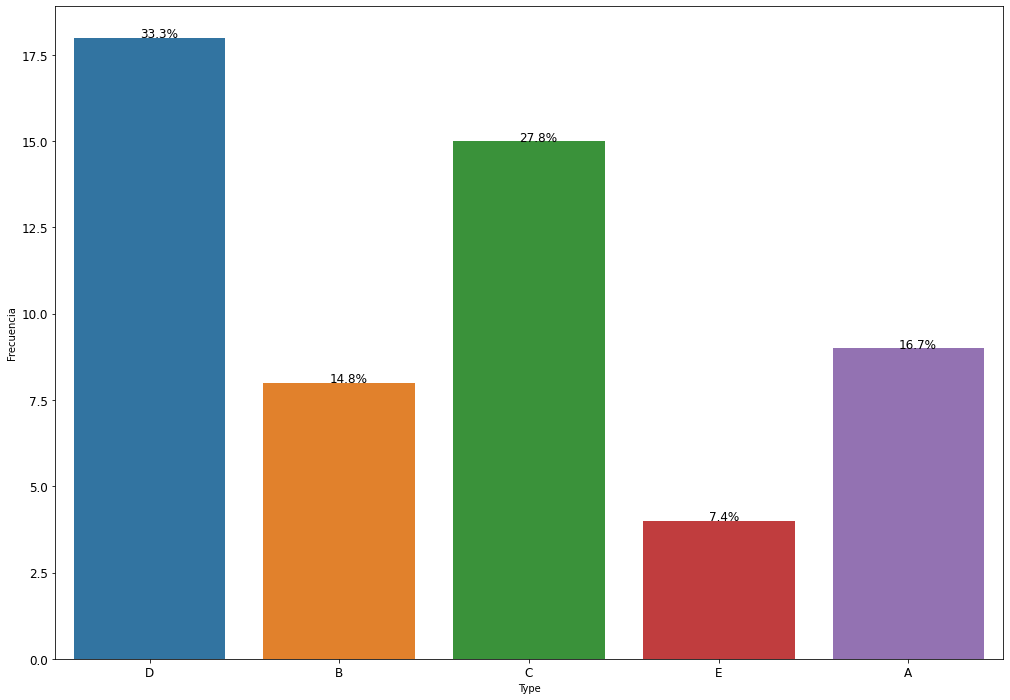

In [ ]:
plt.figure(figsize=(17,12))
ax = sns.countplot(Store_df['type'])
plt.xticks(size = 12)
plt.xlabel('Type')
plt.yticks(size = 12)
plt.ylabel('Frecuencia')

without_hue(ax, Store_df.type)

In [ ]:
Store_df['cluster'].value_counts()

3     7
6     6
10    6
15    5
13    4
14    4
11    3
4     3
8     3
1     3
9     2
7     2
2     2
12    1
5     1
16    1
17    1
Name: cluster, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


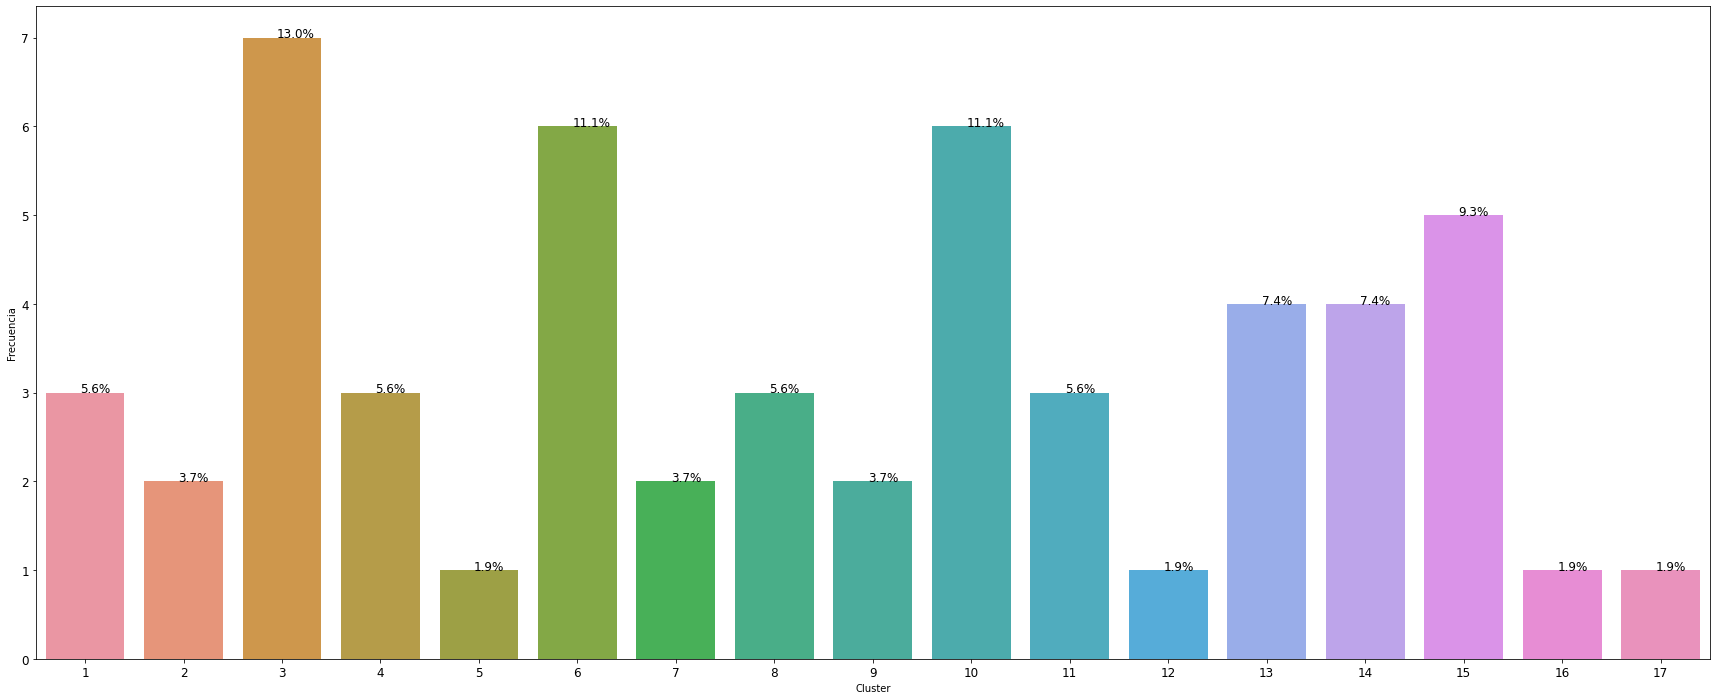

In [ ]:
plt.figure(figsize=(30,12))
ax = sns.countplot(Store_df['cluster'])
plt.xticks(size = 12)
plt.xlabel('Cluster')
plt.yticks(size = 12)
plt.ylabel('Frecuencia')

without_hue(ax, Store_df.cluster)

##Transactions

In [ ]:
Trans_df.shape

(83488, 3)

In [ ]:
pd.set_option('display.max_rows', Trans_df.isna().sum().shape[0]+1)
print(Trans_df.isna().sum())

date            0
store_nbr       0
transactions    0
dtype: int64


In [ ]:
type(Trans_df['date'])
Trans_df.date = pd.to_datetime(Trans_df.date, format = '%Y-%m-%d')
Trans_df['date'] = Trans_df.date

In [ ]:
Trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [ ]:
Trans_df.head(8)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874


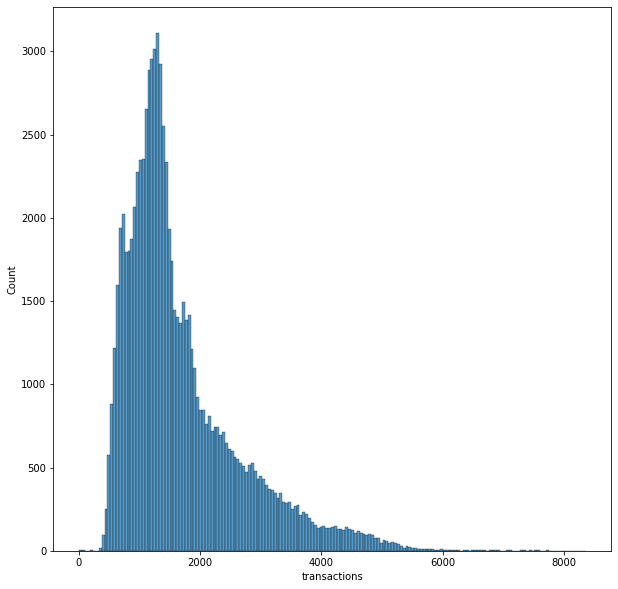

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(x = Trans_df['transactions'], data = Trans_df)

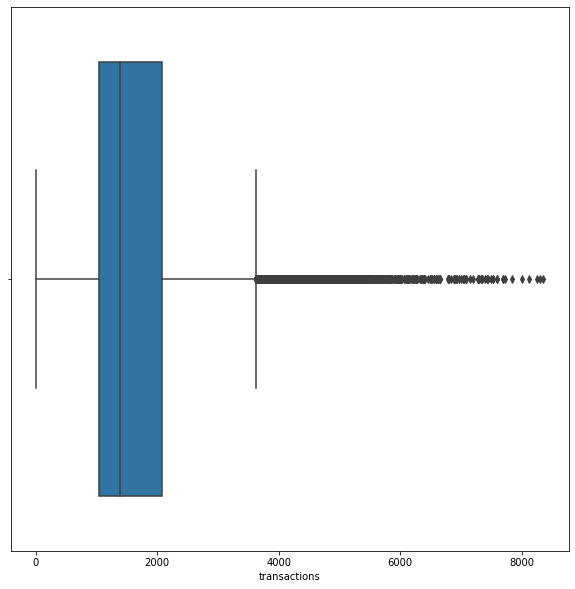

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(x = Trans_df['transactions'], data = Trans_df)

In [ ]:
Trans_df['store_nbr'].value_counts()

39    1678
38    1678
26    1678
31    1678
33    1678
34    1678
37    1678
27    1677
28    1677
32    1677
23    1677
40    1677
41    1677
44    1677
45    1677
46    1677
47    1677
48    1677
50    1677
51    1677
49    1677
2     1677
16    1677
5     1677
54    1676
3     1676
4     1676
6     1676
8     1676
9     1676
19    1676
35    1676
13    1676
1     1676
15    1676
11    1676
10    1675
7     1675
17    1674
43    1672
30    1655
14    1638
12    1616
25    1615
24    1577
18    1566
36    1551
53    1167
20     909
29     874
21     748
42     720
22     671
52     118
Name: store_nbr, dtype: int64

In [ ]:
Trans_df['store_nbr'].unique()

array([25,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 23, 24, 26, 27, 28, 30, 31, 32, 33, 34, 35, 37, 38, 39,
       40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 36, 53, 20, 29, 21,
       42, 22, 52])

In [ ]:
len(Trans_df['store_nbr'])

83488

In [ ]:
Trans_df['transactions'].describe()

count    83488.000000
mean      1694.602158
std        963.286644
min          5.000000
25%       1046.000000
50%       1393.000000
75%       2079.000000
max       8359.000000
Name: transactions, dtype: float64

In [ ]:
stats.kstest(Trans_df['transactions'], 'norm')

KstestResult(statistic=0.9999997133484281, pvalue=0.0)

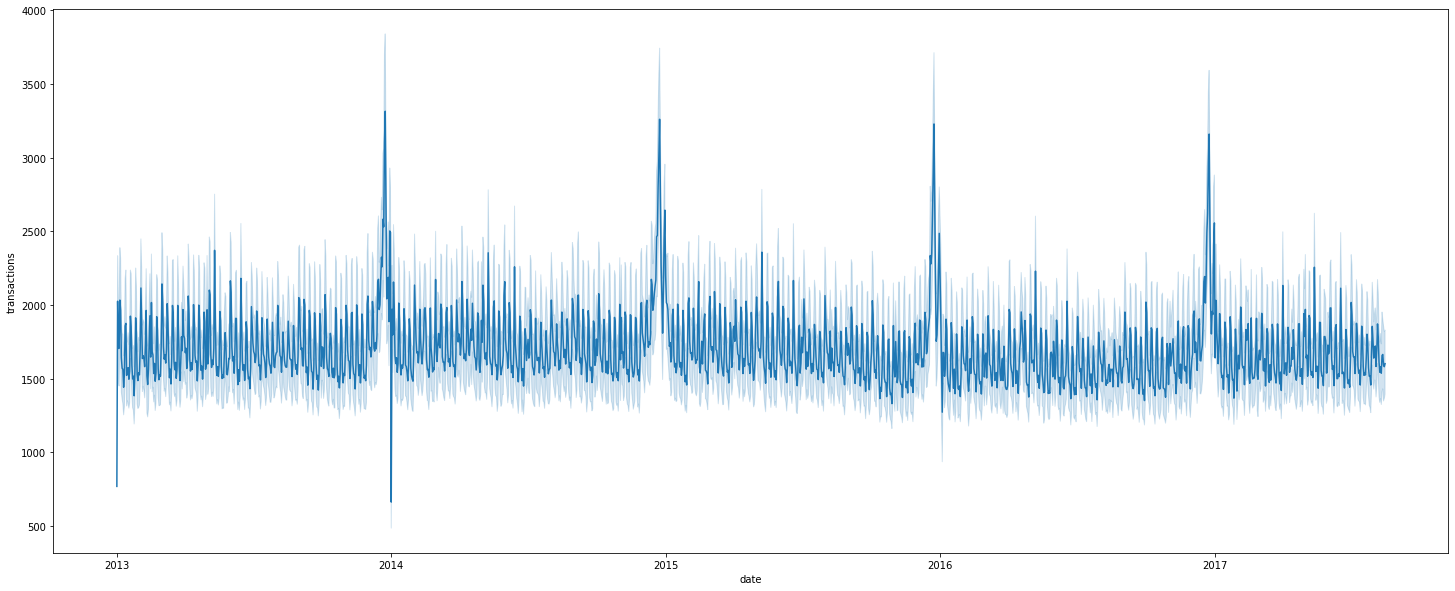

In [ ]:
plt.figure(figsize=(25,10))
sns.lineplot(x = Trans_df['date'], y = Trans_df['transactions'], data = Trans_df)
ax.set_title('Store Transaction Time Series');

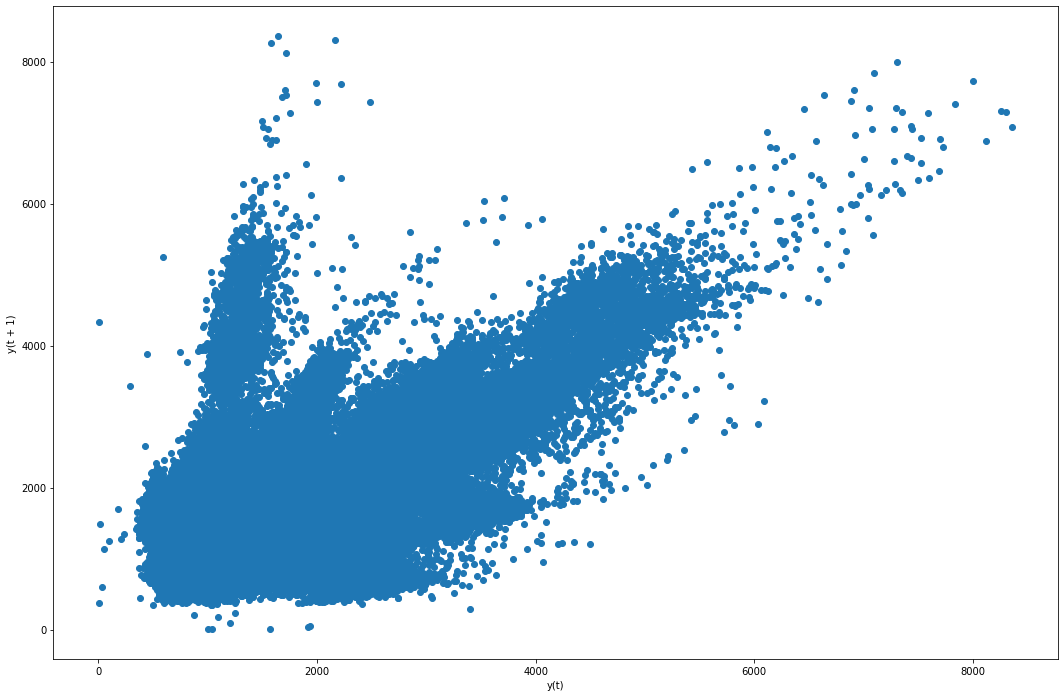

In [ ]:
plt.figure(figsize=(18,12))
lag_plot(Trans_df['transactions'], lag=1)